In [32]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Importing the cleaned and processed data

In [33]:
import pandas as pd
df = pd.read_csv("/content/gdrive/MyDrive/Capstone Project /cleaned.csv")
df.head()

,article,highlights,cleaned_text
0,by . associated press . published: . 14:11 est...,bishop john folda north dakota taking time dia...,associated press published est october updated...
1,(cnn) -- ralph mata was an internal affairs li...,criminal complaint cop used role help cocaine ...,cnn ralph mata internal affair lieutenant miam...
2,a drunk driver who killed a young woman in a h...,craig ecclestontodd drunk least three pint dri...,drunk driver killed young woman headon crash c...
3,(cnn) -- with a breezy sweep of his pen presid...,nina do santos say europe must ready accept sa...,cnn breezy sweep pen president vladimir putin ...
4,fleetwood are the only team still to have a 10...,fleetwood top league one win scunthorpe peterb...,fleetwood team still record sky bet league one...


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308870 entries, 0 to 308869
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   article       308870 non-null  object
 1   highlights    308870 non-null  object
 2   cleaned_text  308870 non-null  object
dtypes: object(3)
memory usage: 7.1+ MB


In [35]:
# create a subset of first 50,000 rows
subset = df.head(50000)

# save the subset to a new file
subset.to_csv('/content/gdrive/MyDrive/Capstone Project /subset_dataset.csv', index=False)

In [36]:
train_df = pd.read_csv("/content/gdrive/MyDrive/Capstone Project /subset_dataset.csv")
train_df.head()

,article,highlights,cleaned_text
0,by . associated press . published: . 14:11 est...,bishop john folda north dakota taking time dia...,associated press published est october updated...
1,(cnn) -- ralph mata was an internal affairs li...,criminal complaint cop used role help cocaine ...,cnn ralph mata internal affair lieutenant miam...
2,a drunk driver who killed a young woman in a h...,craig ecclestontodd drunk least three pint dri...,drunk driver killed young woman headon crash c...
3,(cnn) -- with a breezy sweep of his pen presid...,nina do santos say europe must ready accept sa...,cnn breezy sweep pen president vladimir putin ...
4,fleetwood are the only team still to have a 10...,fleetwood top league one win scunthorpe peterb...,fleetwood team still record sky bet league one...


In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article       50000 non-null  object
 1   highlights    50000 non-null  object
 2   cleaned_text  50000 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


## Importing all the necessary libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os
from nltk.corpus import stopwords
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,Flatten,Dropout,BatchNormalization,Embedding,Input,TimeDistributed
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

## Splitting the dataset into training and validation

In [39]:
X_train,X_val,Y_train,Y_val=train_test_split(train_df['cleaned_text'],train_df['highlights'],test_size=0.3,random_state=29)
print(len(X_train),len(Y_train))
print(len(X_val),len(Y_val))

35000 35000
15000 15000


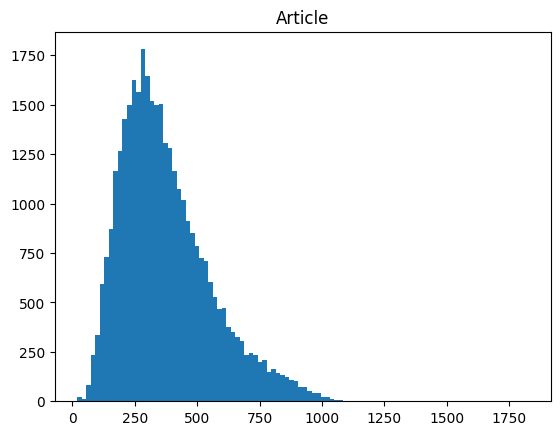

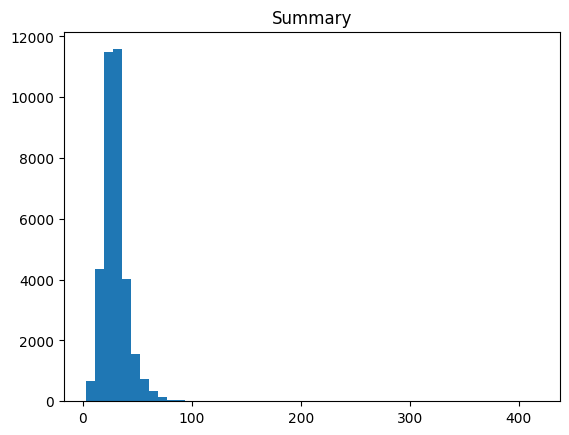

In [40]:
art_len=[len(i.split()) for i in X_train]
sum_len=[len(i.split()) for i in Y_train]
plt.hist(art_len,bins=100)
plt.title('Article')
plt.show()
plt.hist(sum_len,bins=50)
plt.title('Summary')
plt.show()

In [41]:
max_art_len=500
max_sum_len=100

## Vectorization

The purpose of this code is to preprocess the text data for training and validation of an abstraction-based text summarization model using the CNN/Daily Mail dataset.

In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [43]:
article_tokenizer=Tokenizer(oov_token='<UNK>')
article_tokenizer.fit_on_texts(X_train)
tokenized_X_train=article_tokenizer.texts_to_sequences(X_train)
tokenized_X_val=article_tokenizer.texts_to_sequences(X_val)
art_vocab_size=len(article_tokenizer.word_index)+1

In [44]:
padded_X_train=pad_sequences(tokenized_X_train,maxlen=max_art_len,padding='post',truncating='post')
padded_X_val=pad_sequences(tokenized_X_val,maxlen=max_art_len,padding='post',truncating='post')

In [45]:
print(padded_X_train.shape,padded_X_val.shape)

(35000, 500) (15000, 500)


In [46]:
summary_tokenizer=Tokenizer(oov_token='<UNK>')
summary_tokenizer.fit_on_texts(Y_train)
tokenized_Y_train=summary_tokenizer.texts_to_sequences(Y_train)
tokenized_Y_val=summary_tokenizer.texts_to_sequences(Y_val)

In [47]:
sum_vocab_size=len(summary_tokenizer.word_index)+1

In [48]:
padded_Y_train=pad_sequences(tokenized_Y_train,maxlen=max_sum_len,padding='post',truncating='post')
padded_Y_val=pad_sequences(tokenized_Y_val,maxlen=max_sum_len,padding='post',truncating='post')

In [49]:
print(padded_Y_train.shape,padded_Y_val.shape)

(35000, 100) (15000, 100)


In [50]:
reverse_art_index=article_tokenizer.index_word
reverse_sum_index=summary_tokenizer.index_word
sum_wordindex=summary_tokenizer.word_index

## Modelling

This is code for building a sequence-to-sequence (Seq2Seq) model for text summarization using the Keras API of TensorFlow.

The first block of code defines the encoder. It takes as input a sequence of words (encoder_inputs) and applies an embedding layer to convert each word into a dense vector of fixed length (encoder_emb). The embedded sequence is then passed through an LSTM layer with 300 hidden units (encoder_lstm1). This layer returns both the sequence of hidden states (enclstm1_outputs) and the final hidden state (enclstm1_h) and cell state (enclstm1_c) of the LSTM.

The second block of code defines the decoder. It takes as input a sequence of words (decoder_inputs) and applies an embedding layer (decoder_emb) to convert each word into a dense vector of fixed length. The embedded sequence is then passed through an LSTM layer with 300 hidden units (decoder_lstm1), initialized with the final hidden state and cell state of the encoder LSTM (enclstm1_h and enclstm1_c). This layer returns both the sequence of hidden states (declstm1_output) and the final hidden state (declstm1_h) and cell state (declstm1_c) of the LSTM.

The third block of code defines the output layer, which is a fully connected layer with a softmax activation function that predicts the probability distribution over the vocabulary of possible words in the summary. The TimeDistributed layer is used to apply the same dense layer to each time step of the decoder output sequence.

Finally, the model is instantiated as a Keras Model object, with the encoder_inputs and decoder_inputs as inputs and the output as the output. The model is then printed out using the summary() function, which displays a summary of the architecture of the model.

In [51]:
encoder_inputs=Input(shape=(max_art_len,))
encoder_emb=Embedding(art_vocab_size,50,trainable=True,name='Encoder_Embedding_layer')(encoder_inputs)
encoder_lstm1=LSTM(128,return_sequences=True,return_state=True,name='Encoder_LSTM1')
enclstm1_outputs,enclstm1_h,enclstm1_c=encoder_lstm1(encoder_emb)


decoder_inputs=Input(shape=(None,))
decoder_em=Embedding(sum_vocab_size,50,trainable=True,name='Decoder_Embedding_layer')
decoder_emb=decoder_em(decoder_inputs)

decoder_lstm1=LSTM(128,return_sequences=True,return_state=True,name='Decoder_LSTM1')
declstm1_output,declstm1_h,declstm1_c=decoder_lstm1(decoder_emb,initial_state=[enclstm1_h,enclstm1_c])

output_layer=TimeDistributed(Dense(sum_vocab_size,activation='softmax',name='softmax'))
output=output_layer(declstm1_output)

model=Model([encoder_inputs,decoder_inputs],output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 Encoder_Embedding_layer (Embed  (None, 500, 50)     9716350     ['input_3[0][0]']                
 ding)                                                                                            
                                                                                                  
 Decoder_Embedding_layer (Embed  (None, None, 50)    2957050     ['input_4[0][0]']          

In [52]:
#from keras.metrics import SparseCategoricalAccuracy
#
#model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=[SparseCategoricalAccuracy()])

#model.fit([padded_X_train,padded_Y_train[:,:-1]],padded_Y_train[:,1:],
#          epochs=1,
#          validation_data=([padded_X_val,padded_Y_val[:,:-1]],padded_Y_val[:,1:]),
#          batch_size=64)
#
#_, acc = model.evaluate([padded_X_val, padded_Y_val[:,:-1]], padded_Y_val[:,1:], verbose=0)
#print('Accuracy: %.2f%%' % (acc*100))


For the first model training (LSTM):
547/547 [==============================] - 16763s 31s/step - 
loss: 3.1436 - 
sparse_categorical_accuracy: 0.7111 - 
val_loss: 2.6104 - 
val_sparse_categorical_accuracy: 0.7118
Accuracy: 71.18%

### Saving the model 

In [53]:
# model.save('/content/gdrive/MyDrive/Capstone Project /Model1_LSTM.h5')

In [54]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the pre-trained LSTM model
from keras.models import load_model

model = load_model('/content/gdrive/MyDrive/Capstone Project /Model1_LSTM.h5')

In [55]:
# Tokenizer to preprocess the input text
#tokenizer = Tokenizer(num_words=10000)

# Input text to be summarized
#input_text = df['cleaned_text'][0]

# Tokenize the input text and convert it to a sequence of integers
#input_seq = tokenizer.texts_to_sequences(input_text)

# Pad the sequence to ensure that it has the same length as the sequences used during training
#input_seq = pad_sequences(input_seq, maxlen=500, padding='post')

In [56]:
# Generate a summary using the pre-trained LSTM model
#summary_seq = model.predict(input_seq)


In [57]:
# Convert the sequence of integers back to text
#summary_text = tokenizer.sequences_to_texts(summary_seq)[0]

#print(summary_text)

## Inference


The code you provided is for creating two separate models: an encoder model (infencoder_model) and a decoder model (infdecoder_model) that can be used for inference or prediction purposes.

The infencoder_model takes in the encoder_inputs and returns the output of the encoder_lstm1 layer, as well as the final hidden state (enclstm1_h) and cell state (enclstm1_c) of the LSTM layer. This is because we need these states as input for the decoder model during inference.

The infdecoder_model takes in the decoder_inputs as well as the final hidden state (infdecoder_model_state_input_h) and cell state (infdecoder_model_state_input_c) of the LSTM layer from the encoder model. It then returns the output of the output_layer (which is the predicted sequence) as well as the final hidden state (infdec_h) and cell state (infdec_c) of the LSTM layer for the current time step. This output state can be used as input to the decoder model for the next time step.

Overall, these two models are used together during inference to predict the output sequence based on the input sequence, using the hidden and cell states from the encoder model to initialize the decoder model.

In [58]:
infencoder_model=Model(inputs=[encoder_inputs],outputs=[enclstm1_outputs,enclstm1_h,enclstm1_c])

infdecoder_model_state_input_h=Input(shape=(128,),name='infdec_I1')
infdecoder_model_state_input_c=Input(shape=(128,),name='infdec_I2')

infdeclstm1_output,infdec_h,infdec_c=decoder_lstm1(decoder_emb,initial_state=[infdecoder_model_state_input_h,
                                                                                                infdecoder_model_state_input_c
                                                                                               ])

infdec_output=output_layer(infdeclstm1_output)                         

infdecoder_model=Model(inputs=[decoder_inputs]+[infdecoder_model_state_input_h,infdecoder_model_state_input_c],
                       outputs=[infdec_output]+[infdec_h,infdec_c])

In [59]:
infencoder_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500)]             0         
                                                                 
 Encoder_Embedding_layer (Em  (None, 500, 50)          9716350   
 bedding)                                                        
                                                                 
 Encoder_LSTM1 (LSTM)        [(None, 500, 128),        91648     
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
Total params: 9,807,998
Trainable params: 9,807,998
Non-trainable params: 0
_________________________________________________________________


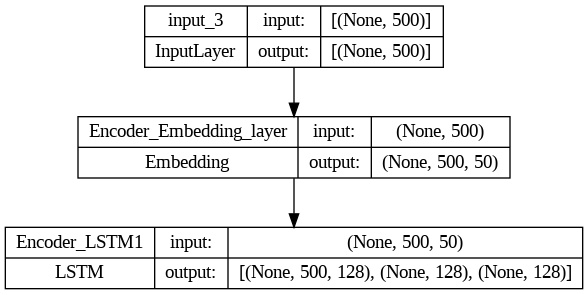

In [60]:
plot_model(infencoder_model,show_shapes=True)

In [61]:
infdecoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 Decoder_Embedding_layer (Embed  (None, None, 50)    2957050     ['input_4[0][0]']                
 ding)                                                                                            
                                                                                                  
 infdec_I1 (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 infdec_I2 (InputLayer)         [(None, 128)]        0           []                         

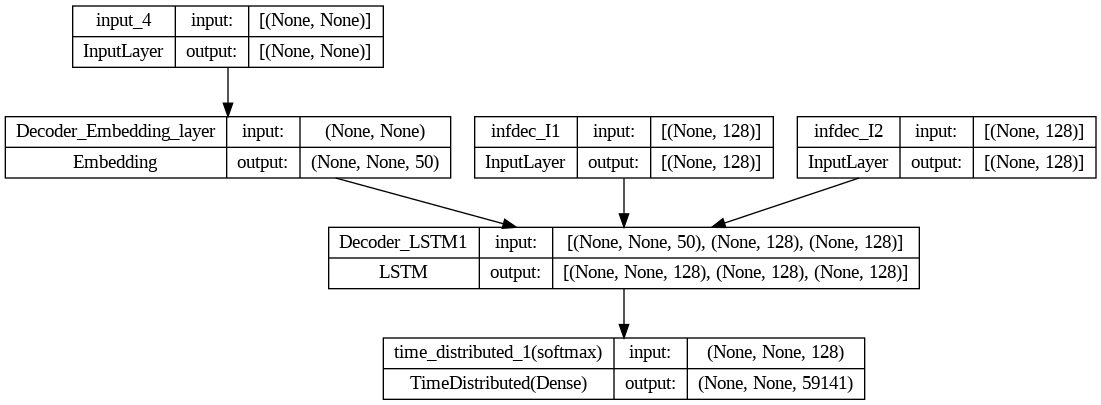

In [62]:
plot_model(infdecoder_model,show_shapes=True)